In [14]:
#imports 
import json
import copy
import os
from pathlib import Path
import numpy as np 
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
'''
Two functions that clean up the data, and allow us to access the list as list object and not a str object
'''

def convert_to_array(data_):
    
    '''
    Function converts last column to an array of floats(if possible)
    '''
    
    data = copy.deepcopy(data_)
    
    row_hit_list = []
    for i, row in enumerate(data):
        
        try:
            
            #try converting into an array
            array = json.loads(row[-1])
            if isinstance(array, list):
                row[-1] = array
            
            #some error 
            else:
                row[-1] = None
        
        except:
            row[-1] = None
            row_hit_list.append(i)
    
    
    #remove the rows we do not want 
    if row_hit_list:
        data = np.delete(data, row_hit_list, axis=0)
    
    return data 

def remove_none(data_):
    
    data = copy.deepcopy(data_)
    row_hit_list = []
    for i, row in enumerate(data):
        
        if None in row:
            row_hit_list.append(i)
            
    if row_hit_list:
        data = np.delete(data, row_hit_list, axis = 0)
        
    return data

In [3]:
'''
Function that takes in clean data and then passes a one hot whether or not it is a sprint stage.
The current classification is whether or not there is at some point in the top 50 a string of 38 zeros.
'''

def longest_zero(array):
    
    '''
    Function takes in an array as as input 
    and returns the largest consecutive 
    instance of zeros 
    '''
    best_length = 0
    n = len(array)
    
    for i in range(n):
        
        if i == 0:
            current_length = 0
        
        if array[i] == 0:
            
            current_length += 1
            
        
        else:
            
            best_length = max(best_length, current_length)
            current_length = 0
    
    best_length = max(best_length, current_length)
    return best_length 


def one_hot(clean_data):
    
    '''
    Takes in clearn input data and modifies to one-hot data
    '''
    data = copy.deepcopy(clean_data)
    for i, row in enumerate(data):
        
        gaps = row[-1]
        if longest_zero(gaps) >= 30:
            
            data[i][-1] = 1
        else:
            data[i][-1] = 0
            
    return data
            

In [4]:
'''
Gather together clean tour, giro and vuelta data and one_hot it
'''


save_directory = '/Users/owainthorp/Documents/Coding/Project/Data/Top50'

'''
Giro 
'''
file_name = 'Top 50 giro-d-italia 2000-2023.csv'
data_path = os.path.join(save_directory, file_name)

df = pd.read_csv(data_path)
giro = df.iloc[:,1:].values  # Features
giro = convert_to_array(giro)
giro = remove_none(giro)

'''
Tour
'''
file_name = 'Top 50 tour-de-france 2000-2023.csv'
data_path = os.path.join(save_directory, file_name)

df = pd.read_csv(data_path)
tour = df.iloc[:,1:].values  # Features
tour = convert_to_array(tour)
tour = remove_none(tour)
'''
Vuelta
'''
file_name = 'Top 50 vuelta-a-espana 2000-2023.csv'
data_path = os.path.join(save_directory, file_name)

df = pd.read_csv(data_path)
vuelta = df.iloc[:,1:].values  # Features
vuelta = convert_to_array(vuelta)
vuelta = remove_none(vuelta)

'''
One hot the data
'''
tour = one_hot(tour)
giro = one_hot(giro)
vuelta = one_hot(vuelta)

data = np.vstack((tour,giro,vuelta))
data_for_preprocessing = data[:, 2:]

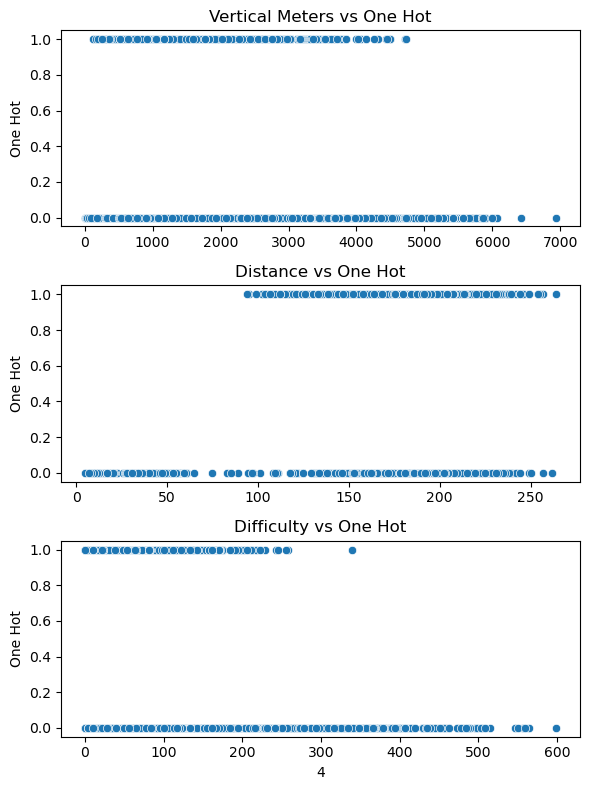

In [5]:
dataframe = pd.DataFrame(data)
distance = dataframe.iloc[:, 2].values
vertical_meters = dataframe.iloc[:, 3].values
difficulty = dataframe.iloc[:, 4]
one_hot = dataframe.iloc[:,-1]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8))

# Scatter plot using Seaborn
sns.scatterplot(x=vertical_meters, y=one_hot, ax=ax1)
ax1.set_ylabel('One Hot')
ax1.set_title('Vertical Meters vs One Hot')

sns.scatterplot(x=distance, y=one_hot, ax=ax2)
ax2.set_ylabel('One Hot')
ax2.set_title('Distance vs One Hot')

sns.scatterplot(x=difficulty, y=one_hot, ax=ax3)
ax3.set_ylabel('One Hot')
ax3.set_title('Difficulty vs One Hot')

plt.tight_layout()
plt.show()

In [27]:
X, y = data_for_preprocessing[:,:-1], data_for_preprocessing[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.int32)
y_test = np.array(y_test, dtype=np.int32)
X_val = np.array(X_val, dtype = np.float32)
y_val = np.array(y_val, dtype=np.int32)

In [29]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5754 - loss: 22.7573 - val_accuracy: 0.7565 - val_loss: 4.0175
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7640 - loss: 3.9964 - val_accuracy: 0.7565 - val_loss: 2.5565
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7874 - loss: 2.2670 - val_accuracy: 0.7261 - val_loss: 1.6484
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8064 - loss: 1.5100 - val_accuracy: 0.7913 - val_loss: 1.4410
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8121 - loss: 1.4793 - val_accuracy: 0.7826 - val_loss: 2.1295
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8141 - loss: 1.3354 - val_accuracy: 0.7652 - val_loss: 1.8178
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8102 - loss: 1.5305 - val_accuracy: 0.8609 - val_loss: 1.2746
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7770 - loss: 1.5147 - val_accuracy: 0.7565 - val_loss

In [30]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - accuracy: 0.8244 - loss: 1.3857


In [ ]:
'''
Not bad!
'''